# Lesson 9 - Overfitting

> What is overfitting and how can it be avoided?

## Learning Objectives
Overfitting is a phenomena that can always occur when a model is fitted to data. Therefore, it is important to understand what it entails and how it can be avoided. In this notebook we will address these three questions related to overfitting:
1. What is overfitting?
2. How can we measure overfitting?
3. How can overfitting be avoided?

## References
* Chapter 5: Overfitting and its avoidance of _Data Science for Business_ by F. Provost and P. Fawcett


## Homework
* Work through part 2 of the notebook concerning the housing dataset.
* Solve exercises in the notebook. In particular, tune a random forest for the churn dataset in part 3.

## What is overfitting?

Already John von Neumann, one of the founding fathers of computing, knew that fitting complex models to data is a tricky business:
>With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.
>
> \- John von Neumann

When we fit a model to data, we always have to be careful not to overfit. If we overfit the model this means that the model learned specific aspects of the training data and does not *generalise* to new, unseen data. Instead of learning useful relations between the input feature and the target the model has memorised the training samples. If this happens the model will perform very poorly on new data and therefore we want to make sure this does not happen.

Fortunately, there are tools that can help detect and avoid overfitting. One tool we already used: splitting the data into two sets. Measuring the performance difference between the training and validation set already helps identifying when we are overfitting. In this lecture we will see an even more systematic way of splitting the data, namely *cross-validation*.

## Load libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

np.warnings.filterwarnings('ignore')

## Helper functions
by L. Van Werra

In [2]:
def make_polynomial_data(weight, n_samples=100, seed=42):
    """
    Creates noisy polynomial data.
    Args:
        weight (array): polynomial weights in descending order
        n_samples (int): number of samples
        seed (int): random seed
    returns:
        x (array): x-values
        y (array): y-values
    """

    np.random.seed(seed)

    # generate random points on the x axis
    x = (0.5-np.random.rand(n_samples))*2

    # sort the array
    x = np.sort(x)

    # evalute polynomial with weight w at positions x
    y_true = np.polyval(weight, x)

    # add noise samples from the normal gaussian
    # distribution to the data.
    y = y_true + np.random.randn(n_samples)

    return x, y

class PolynomialRegressor:
    """
    Scikit-like interface to fit polynomials.
    """
    def __init__(self, degree=0, w_hat=None):
        """
        Initialize polynomial fitter.
        args:
            degree (int): degree of polynomial to fit, default: 0.
            w_hat (array): polynomial weights, default: None.
        """
        self.degree = degree
        self.w_hat = w_hat

    def fit(self, x, y):
        """Fit polynomial to x,y data."""
        self.w_hat = np.polyfit(x, y, self.degree)
        return self

    def predict(self, x):
        """Predict y with fitted polynomial."""
        if self.w_hat is not None:
            return np.polyval(self.w_hat, x)
        else:
            raise ValueError('You need to first fit the model.')

    def evaluate(self, x, y):
        """Evaluate RMSE score of y and predictions for y."""
        if self.w_hat is not None:
            y_hat = np.polyval(self.w_hat, x)
            return rmse(y, y_hat)
        else:
            raise ValueError('You need to first fit the model.')

    def get_params(self, **kwargs):
        return {'w_hat': self.w_hat,
                'degree': self.degree}

def rmse(y, yhat):
    """A utility function to calculate the Root Mean Square Error (RMSE).
    Args:
        y (array): Actual values for target.
        yhat (array): Predicted values for target.
    Returns:
        rmse (double): The RMSE.
    """
    return np.sqrt(mean_squared_error(y, yhat))

## Part 0: tqdm
Before starting with overfitting we introduce the tqdm library. In this notebook we will make extensive use of for-loops and tqdm is a very handy addition to them. With just one expression you can add a progress bar to your for loop. Let say you have a for-loop that does some computation:

In [3]:
for i in range(1000):
    #do something
    a = i**2
    time.sleep(0.01)

In [4]:
for i in tqdm(range(1000)):
    #do something
    a = i**2
    #time.sleep(0.01)

100%|██████████| 1000/1000 [00:00<00:00, 332881.27it/s]


In [5]:
sum_i = 0
for i in tqdm([1,2,3,4,5]):
    sum_i += i
    time.sleep(1)
print('sum:', sum_i)

100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

sum: 15


## Part 1: Overfitting Polynomials

### Polynomials
To study the nature of overfitting, we start looking at a toy example of a polynomial. Later we will see our findings are not specific to polynomials and can be extended to other *supervised* machine learning methods such as linear regressors, tree classifiers or random forests. 

A polynomial of degree $n$ has the form:
$$f(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots+w_n\cdot x^n$$

### Generate data

In this block we generate a random polynomial of degree 3 with the helper function `get_polynomial_data`. The polynomial has the form:
$$f(x) = 10 \cdot x^3 -5 \cdot x $$
If you are interested in creating or fitting polynomial data check out the functions `numpy.polyval` and `numpy.polyfit`. In this lesson we will use wrapper functions around them. The function `make_polynomial_data(w, n_samples=100)` evaluates the polymial defined by `w` on `n_samples` random points and adds some noise to it.

In [6]:
weights = np.array([10, 0, -5, 0]) # weights for x^3,..,x^0
X, y = make_polynomial_data(weights, n_samples=100)#


We can plot the polynomial data in a scatter plot:

In [7]:
def scatter_plot_polynomial(X, y, label='', title='Polynomial data'):
    plt.title(title)
    plt.scatter(X, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend(loc='best')

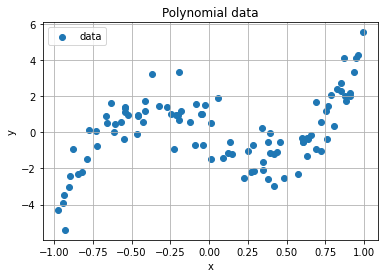

In [8]:
scatter_plot_polynomial(X, y, label='data')
plt.show()

### Train and validation sets
We have already discussed in previous lessons that a validation set helps us investigate overfitting. The model is trained with the training set and its performance is measured using the validation set. We will do the same here.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,)

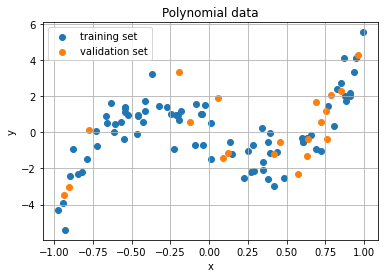

In [10]:
scatter_plot_polynomial(X_train, y_train, label='training set')
scatter_plot_polynomial(X_valid, y_valid, label='validation set')

Now lets fit a polynomial to the generated data. We can use `PolyFit` class to fit a polynomial to the data. We can pass the degree as an argument and then use the `fit`, `predict` and `evaluate` functions known from `scikit-learn`. 

In [11]:
pr = PolynomialRegressor(degree=3)
pr.fit(X_train, y_train)

Now we want to see how that polynomial looks like on a range from [-1, 1]:

In [12]:
X_lin = np.linspace(-1, 1, 1000)
y_fit = pr.predict(X_lin)

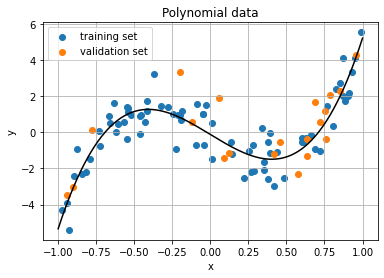

In [13]:
scatter_plot_polynomial(X_train, y_train, label='training set')
scatter_plot_polynomial(X_valid, y_valid, label='validation set')
plt.plot(X_lin, y_fit, label='fit', c='black')
plt.show()

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

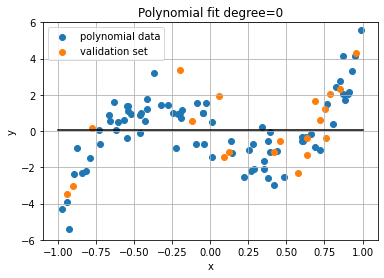

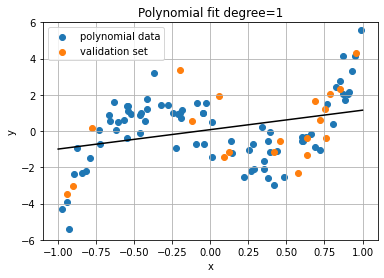

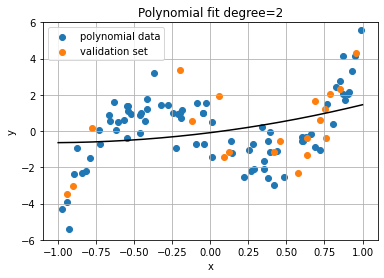

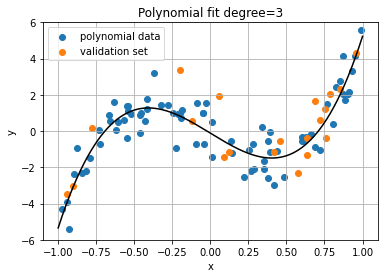

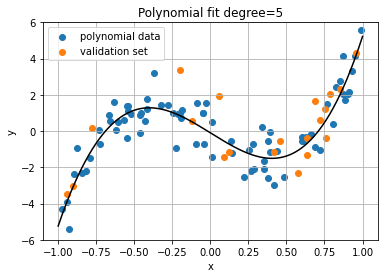

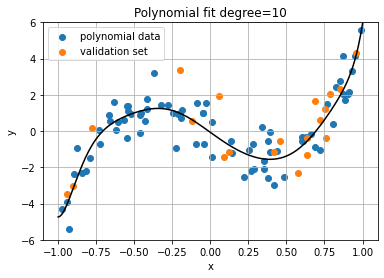

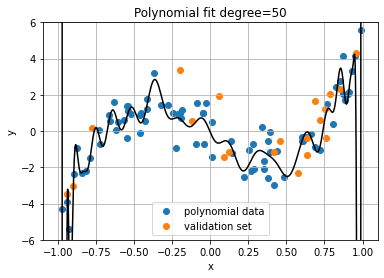

In [14]:
for degree in [0, 1, 2, 3, 5, 10, 50]:
    pr = PolynomialRegressor(degree=degree)
    pr.fit(X_train, y_train)
    y_fit = pr.predict(X_lin)
    
    title = f'Polynomial fit degree={degree}'
    scatter_plot_polynomial(X_train, y_train, label='polynomial data', title=title)
    scatter_plot_polynomial(X_valid, y_valid, label='validation set', title=title)
    plt.plot(X_lin, y_fit, label='fit', c='black')
    
    plt.ylim([-6, 6])
    plt.show()

By just looking at the curves we can observe **3 regimes**:

**Underfitting (degree<3):**
The model is not able to fit the complexity of the data properly. The fit is bad for both the training and the validation set.

**Fit is just right (degree=3):**
The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

**Overfitting (degree>3:**
The model starts fitting the noise in the dataset. While the fit for the training data gets even better the fit for the validation set gets worse.


### Fitting graph
In the next step we want to quantify the previous observation. To do this we calculate the training and and validation error for each degree and plot them in a single graph. The resulting graph is called the **fitting graph**.

In [15]:
rmse_train = []
rmse_valid = []
degrees = list(range(0, 30))

for degree in tqdm(degrees):
    pr = PolynomialRegressor(degree=int(degree))
    pr.fit(X_train, y_train)
    rmse_train.append(pr.evaluate(X_train, y_train))
    rmse_valid.append(pr.evaluate(X_valid, y_valid))

100%|██████████| 30/30 [00:00<00:00, 597.57it/s]


In [16]:
def plot_fitting_graph(x, metric_train, metric_valid, metric_name='metric', xlabel='x', yscale='linear'):
    plt.plot(x, metric_train, label='train')
    plt.plot(x, metric_valid, label='valid')
    plt.yscale(yscale)
    plt.title('Fitting graph')
    plt.ylabel(metric_name)
    plt.xlabel(xlabel)
    plt.legend(loc='best')
    plt.grid(True)

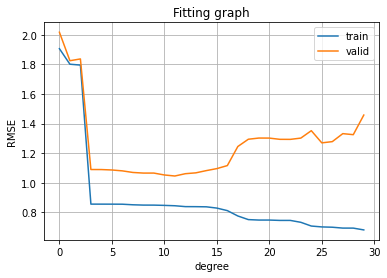

In [17]:
plot_fitting_graph(degrees, rmse_train, rmse_valid, metric_name='RMSE', xlabel='degree')

We can make a few observations:
1. The training error always decreases when adding more degrees.
2. There is a region between 3-15 where the validation error is stable and low. 

Ideally, we would choose the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: **cross-validation**.


### Cross-validation

The idea behind cross validation is to split the data into k equally sized parts, called folds. Each fold gets to be the validation set once while the other folds play the training set part. That means we run k experiments and aggregate the training and validation metrics by averaging them. This is a more robust approach to monitoring overfitting and thanks to `scikit-learn` we only have to adjust one line by adding the `cross_validate` function!

Cross-validate takes care of all the steps, we just have to pass an initialized model, the full dataset and the number of folds with the keyword `cv`. Furthermore, we need to specify the metric to be evaluated and also that we want it to return the scores on the training sets.

In [18]:
rmse_train = []
rmse_valid = []
degrees = list(range(0, 16))
for degree in tqdm(degrees):
    pr = PolynomialRegressor(degree=degree)
    results = cross_validate(pr, X, y,  # full datasets X, 
                             cv=5,      # 5-fold cross validation
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error') # evaluate with RMSE on test set
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 16/16 [00:00<00:00, 63.81it/s]


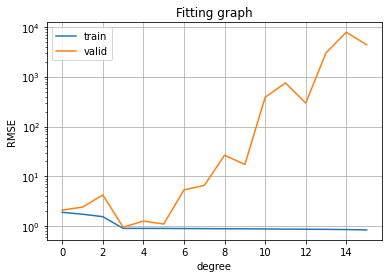

In [19]:
plot_fitting_graph(degrees, rmse_train, rmse_valid, metric_name='RMSE', xlabel='degree', yscale='log')

We can use `np.argmin` to find the element with the minimum validation error. The function returns the index in the array with the minimum value.

In [20]:
np.argmin(rmse_valid) 

3

Since we start counting from 0 in programming this means we are looking for the fourth element in the degrees list:

In [21]:
degrees

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [22]:
degrees[np.argmin(rmse_valid)] # 3rd degree polynomial gives least validation error here

3

### Findings

In these experiments we made some key observations:

1. We can fit polynomials (hurray)
2. There are three regimes when fitting polynomials: **underfitting**, **good fit** and **overfitting**
3. These regimes depend on the degree of the polynomials we are fitting.
4. Increasing the degree of the polynomials will resolve more detailed information in the training data and, therefore, will always decreases the training error.
5. The validation error decreases from the underfitting regime to the good-fit regime and then starts increasing again in the overfitting region.

These observations are not special about polynomials - they hold for fitting machine learning models in general. Let's translate these observations to general machine learning models:

The challenge in fitting models in machine learning is to find the **good fit**. A model that is **too simple** will not be able to capture the complexity of the data and lead to **underfitting**. A model that is **too complex** has the capacity to "memorize" aspects of the data and cause **overfitting**. If we are overfitting, our model will not predict well on unseen data - we say it does not **generalise**. The goal is to find a model that has just the right complexity to fit the data. The **fitting graph** is a tool to identify the sweetspot of model complexity.

**Complexity**

The model complexity comes in different form and shapes. In our polynomial example the complexity is controlled by the `degree` parameter. For a Random Forest the complexity is given by several parameters such as `tree_depth` of and `n_estimators`. 


**More data**

There is another way to reduce overfitting: get more data! In the following exercise you explore how more data influences the fitting graph.

### Exercise #1
Use the `make_polynomial_data` and generate `100_000` samples. Create another fitting graph with cross-validation and compare it to the one with `100` samples.

In the following section we will investigate overfitting in Random Forests.





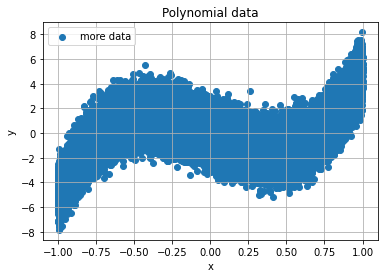

In [23]:
#wupwup
X,y = make_polynomial_data(weight = weights, n_samples= 100000)
scatter_plot_polynomial(label = "more data", X=X, y=y)


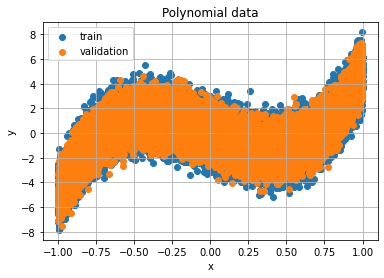

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,)
scatter_plot_polynomial(X = X_train, y = y_train, label = "train")
scatter_plot_polynomial(X = X_valid, y = y_valid, label = "validation")


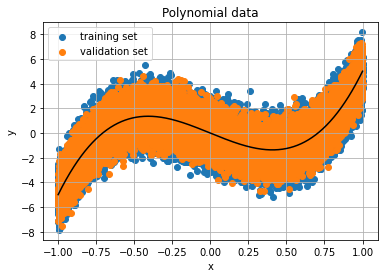

In [25]:
pr = PolynomialRegressor(degree=3)
pr.fit(X_train, y_train)

X_lin = np.linspace(-1, 1, 1000)
y_fit = pr.predict(X_lin)

scatter_plot_polynomial(X_train, y_train, label='training set')
scatter_plot_polynomial(X_valid, y_valid, label='validation set')
plt.plot(X_lin, y_fit, label='fit', c='black')
plt.show()

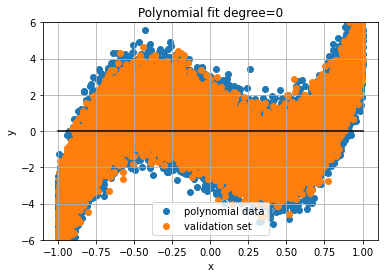

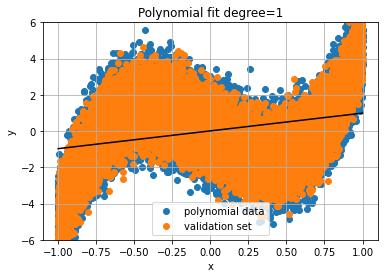

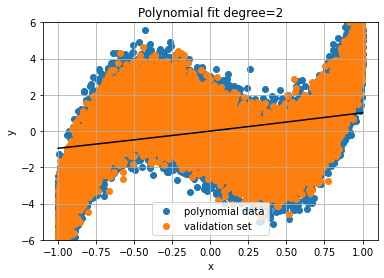

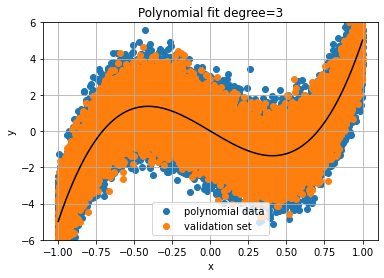

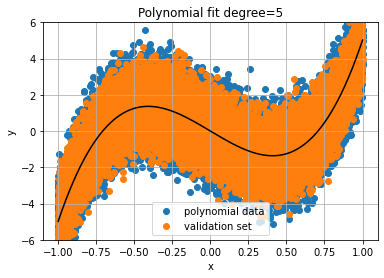

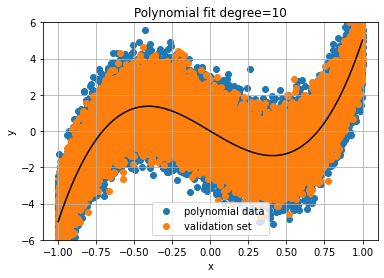

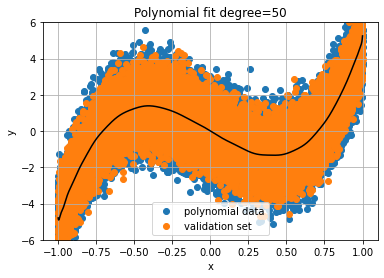

In [26]:
for degree in [0, 1, 2, 3, 5, 10, 50]:
    pr = PolynomialRegressor(degree=degree)
    pr.fit(X_train, y_train)
    y_fit = pr.predict(X_lin)
    
    title = f'Polynomial fit degree={degree}'
    scatter_plot_polynomial(X_train, y_train, label='polynomial data', title=title)
    scatter_plot_polynomial(X_valid, y_valid, label='validation set', title=title)
    plt.plot(X_lin, y_fit, label='fit', c='black')
    
    plt.ylim([-6, 6])
    plt.show()

In [27]:
rmse_train = []
rmse_valid = []
degrees = list(range(0, 30))

for degree in tqdm(degrees):
    pr = PolynomialRegressor(degree=int(degree))
    pr.fit(X_train, y_train)
    rmse_train.append(pr.evaluate(X_train, y_train))
    rmse_valid.append(pr.evaluate(X_valid, y_valid))

100%|██████████| 30/30 [00:02<00:00, 11.17it/s]


In [28]:
def plot_fitting_graph(x, metric_train, metric_valid, metric_name='metric', xlabel='x', yscale='linear'):
    plt.plot(x, metric_train, label='train')
    plt.plot(x, metric_valid, label='valid')
    plt.yscale(yscale)
    plt.title('Fitting graph')
    plt.ylabel(metric_name)
    plt.xlabel(xlabel)
    plt.legend(loc='best')
    plt.grid(True)

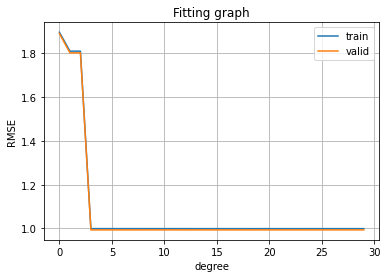

In [29]:
plot_fitting_graph(degrees, rmse_train, rmse_valid, metric_name='RMSE', xlabel='degree')

In [30]:
rmse_train = []
rmse_valid = []
degrees = list(range(0, 16))
for degree in tqdm(degrees):
    pr = PolynomialRegressor(degree=degree)
    results = cross_validate(pr, X, y,  # full datasets X, 
                             cv=5,      # 5-fold cross validation
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error') # evaluate with RMSE on test set
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


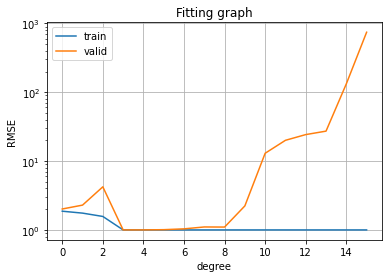

In [31]:
plot_fitting_graph(degrees, rmse_train, rmse_valid, metric_name='RMSE', xlabel='degree', yscale='log')

### Train/validation/test set
Before we move to RandomForests we want to clarify some ambiguity about the terms train, validation and test set. So far we have concentrated on the train and validation set: We train a model on the train set and we evaluate the metrics on the validation set. However, sometimes we also come across the term test set. For example the function we used to split the dataset in to sets: `train_test_split`.

In machine learning each of these sets has a distinct function:

- The **train set** is used to train a model.
- With the **validation set** the model is evaluated. With this information we tune the parameters.
- We only evaluate the final, tuned model on the **test set**. We do not use it to tune the model parameters.

The reason we make the distinction between validation and test set is that by tuning the parameters on the validation performance we might start to overfit the validation data. The test set gives a final sanity check that we actually have a performant model.

In **cross-validation** the concept of train and validation is melted and all training data is also validation data at some point.

## Part 2: Housing dataset
In this section we want to use cross-validation to sytematically tune the parameters of the Random Forest without overfitting. We do it in a linear fashion and tune one parameter after another. This does not guarantee that we find the best global parameters, but runs much faster than a global grid search. We will tune the following parameters:

* n_estimators
* max_depth
* min_samples_leaf
* max_features

First we load the processed housing data:

In [32]:
housing_data = pd.read_csv('housing_processed.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


In [33]:
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

### Untuned model
We want to first evaluate the untuned model to get a baseline:

In [34]:
rf = RandomForestRegressor(n_jobs=-1)
results = cross_validate(rf, X, y,
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')
print('Train score: %.1f' % -np.mean(results['train_score']))
print('Validation score: %.1f' % -np.mean(results['test_score']))

Train score: 16169.0
Validation score: 61324.8


Now we tune one parameter after another and always choose the best one of the round based on the fitting curve.

### n_estimators

In [35]:
rmse_train = []
rmse_valid = []

n_estimators = [25, 50, 100, 200]
for n in tqdm(n_estimators):
    rf = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 4/4 [01:52<00:00, 28.01s/it]


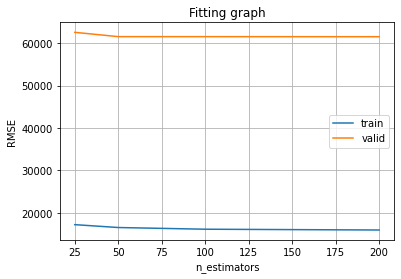

In [36]:
plot_fitting_graph(n_estimators, rmse_train, rmse_valid, metric_name='RMSE', xlabel='n_estimators')

We can zoom in a little bit further to get a better picture of how the validation error behaves:

We see that adding more estimaters further decreases the validation error. We do not overfit by adding more estimators. However, it takes longer to train and evaluate the model as we add more estimators. This is usually not a major concern when experimenting with models but it can be a major constraint when putting it in production. See [this](https://www.wired.com/2012/04/netflix-prize-costs/) example from Netflix.

We choose `n_estimators=100` for the sake of speed but we keep in mind that we could probably further improve the model by adding more estimators. We continue tuning the other parameters:

### tree_depth

In [37]:
rmse_train = []
rmse_valid = []

max_depths = [1, 2, 4, 8, 16, 32, 64]
for d in tqdm(max_depths):
    rf = RandomForestRegressor(n_estimators=100, max_depth=d, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 7/7 [01:43<00:00, 14.86s/it]


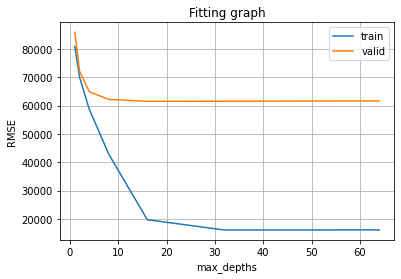

In [38]:
plot_fitting_graph(max_depths, rmse_train, rmse_valid, metric_name='RMSE', xlabel='max_depths')

In [39]:
max_depths[np.argmin(rmse_valid)]

16

### min_samples_leaf

In [40]:
rmse_train = []
rmse_valid = []

min_samples_leaf = [1, 3, 5, 10, 25]
for s in tqdm(min_samples_leaf):
    rf = RandomForestRegressor(n_estimators=100, max_depth=16, min_samples_leaf=s, n_jobs=-1)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 5/5 [01:49<00:00, 21.99s/it]


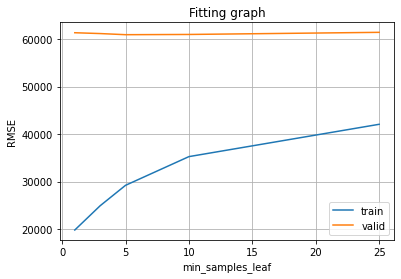

In [41]:
plot_fitting_graph(min_samples_leaf, rmse_train, rmse_valid, metric_name='RMSE', xlabel='min_samples_leaf')

In [42]:
min_samples_leaf[np.argmin(rmse_valid)]

5

### max_features

In [43]:
rmse_train = []
rmse_valid = []

max_features = [.1, .25, .5, .75, 1.]
for mf in tqdm(max_features):
    rf = RandomForestRegressor(n_estimators=100, max_depth=32, min_samples_leaf=5, max_features=mf)
    results = cross_validate(rf, X, y,
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # we average the scores and append them to the list
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

100%|██████████| 5/5 [02:19<00:00, 27.85s/it]


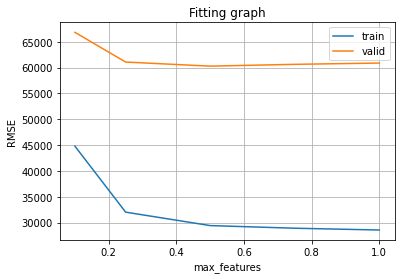

In [44]:
plot_fitting_graph(max_features, rmse_train, rmse_valid, metric_name='RMSE', xlabel='max_features')

In [45]:
max_features[np.argmin(rmse_valid)]

0.5

In [46]:
rf = RandomForestRegressor(n_estimators=100, max_depth=32, min_samples_leaf=5, max_features=0.5, n_jobs=-1)
results = cross_validate(rf, X, y,
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')

In [47]:
print('Train score: %.1f' % -np.mean(results['train_score']))
print('Validation score: %.1f' % -np.mean(results['test_score']))

Train score: 29431.1
Validation score: 60265.8


We see that we improved the RMSE on the validation set by more than $2000 which corresponds to 3-4% improvement. However, note that the validation accuracy is much higher than the training accuracy, so there is a chance that the model is overfitting the training set. 